## Text Similarity using Siamese BiLSTM

Text similarity using Siamese BiLSTM is like having a filter helping you figure out how much two pieces of text resemble each other. It's handy for spotting duplicates or identifying sentences that convey the same idea.

**Text Similarity:** This refers to the degree to which two pieces of text are alike or resemble each other in meaning or content.

**Siamese BiLSTM:** This is a type of neural network architecture that utilizes Long Short-Term Memory (LSTM) units in a bidirectional (Bi) manner. Siamese networks have two identical subnetworks that share the same weights and architecture, and they process two different inputs simultaneously.

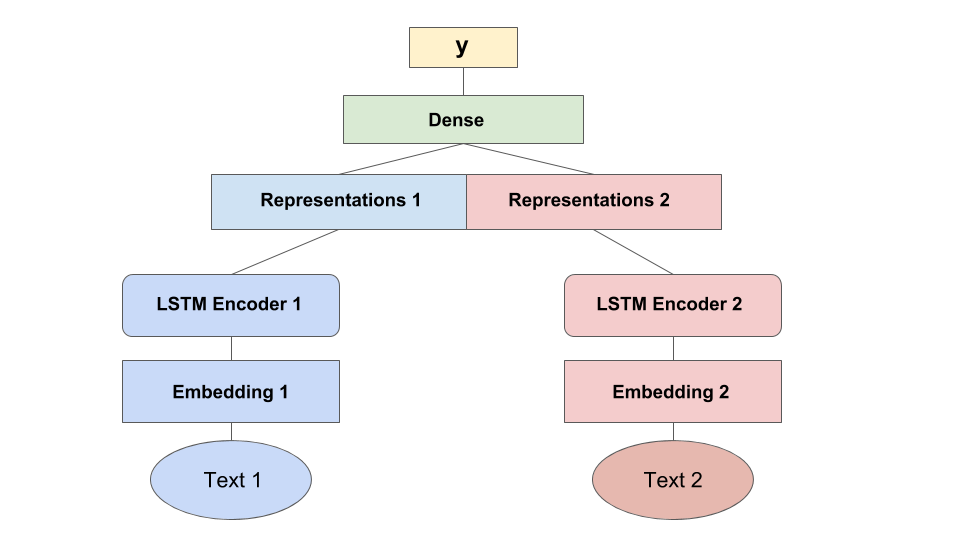

### Table of Contents
1. [Data Preparation](#data-preparation)
2. [Word Embedding](#word-embedding)
3. [Model Training](#model-training)
4. [Model Evaluation](#model-evaluation)
5. [Conclusion](#conclusion)

First things first, let's bring in the tools we need.

In [1]:
from model import SiameseBiLSTM
from inputHandler import word_embed_meta_data, create_test_data
from config import siamese_config

here's a brief explanation of each file imported:

#### model.py
This file holds the blueprint for our Siamese BiLSTM model. It's like the architect's plan for our smart text comparer.

#### inputHandler.py
Here's where we handle all the data preprocessing tasks. Think of it as preparing the ingredients before cooking.

#### config.py
This is our settings file. It stores all the important parameters for our model, like the size of word embeddings and the number of LSTM units.

In [2]:
from operator import itemgetter
from keras.models import load_model
import pandas as pd

### 1. Data Preparation <a id="data-preparation"></a>
Loading the Dataset.

### Dataset Background
The dataset available has been generated by ChatGPT (AI Bot) using the following prompt:

"Give me more CSV sentences like this:

| Sentences1               | Sentences2                       | Is_Similar |
|--------------------------|----------------------------------|------------|
| I had a bad day          | I had so much fun                | 0          |
| I had a bad day          | Everything was terrible today    | 1          |"

This dataset serves as a fundamental resource for studying sentence similarity. It consists of pairs of sentences along with a binary label indicating whether the sentences are similar or not. The sentences vary in their content and sentiment, providing a diverse set for analysis and modeling. The objective is to leverage this dataset to develop our model capable of accurately determining semantic similarity between arbitrary pairs of sentences.

In [3]:
df = pd.read_csv('dataset/sentences.csv')

In [4]:
df

,sentences1,sentences2,is_similar
0,The sun is shining brightly,It's a beautiful day outside,1
1,The sun is shining brightly,It's pouring rain,0
2,I love chocolate ice cream,Vanilla is my favorite flavor,0
3,I love chocolate ice cream,Chocolate is the best,1
4,The cat is sleeping peacefully,The dog is barking loudly,0
...,...,...,...
186,I enjoy playing musical instruments,I'm not musically inclined,0
187,I enjoy playing musical instruments,Music is a universal language,1
188,I prefer watching TV shows over movies,Movies are too long for me,0
189,I prefer watching TV shows over movies,TV shows offer episodic entertainment,1


In [5]:
sentences1 = list(df['sentences1'])
sentences2 = list(df['sentences2'])
is_similar = list(df['is_similar'])
del df

### 2. Word Embedding <a id="word-embedding"></a>

Next, we'll create word embedding metadata for the sentences and prepare the data for training.

We're converting our sentences into embeddings, which are numeric representations of words. This step helps our model understand the meaning of words in a mathematical way.

In [6]:
tokenizer, embedding_matrix = word_embed_meta_data(sentences1 + sentences2,  siamese_config['EMBEDDING_DIM'])

Embedding matrix shape: (624, 50)
Null word embeddings: 1


In [7]:
embedding_meta_data = {
	'tokenizer': tokenizer,
	'embedding_matrix': embedding_matrix
}

In [8]:
sentences_pair = [(x1, x2) for x1, x2 in zip(sentences1, sentences2)]
del sentences1
del sentences2

### 3. Model Training <a id="model-training"></a>

Now comes the fun part – training our Siamese BiLSTM model.

We're defining the model's architecture and training it using our prepared data. Once trained, we save the best-performing model.

In [9]:
from config import siamese_config

In [10]:
class Configuration(object):
    """Dump stuff here"""

In [11]:
CONFIG = Configuration()
CONFIG.embedding_dim = siamese_config['EMBEDDING_DIM']
CONFIG.max_sequence_length = siamese_config['MAX_SEQUENCE_LENGTH']
CONFIG.number_lstm_units = siamese_config['NUMBER_LSTM']
CONFIG.rate_drop_lstm = siamese_config['RATE_DROP_LSTM']
CONFIG.number_dense_units = siamese_config['NUMBER_DENSE_UNITS']
CONFIG.activation_function = siamese_config['ACTIVATION_FUNCTION']
CONFIG.rate_drop_dense = siamese_config['RATE_DROP_DENSE']
CONFIG.validation_split_ratio = siamese_config['VALIDATION_SPLIT']

In [12]:
siamese = SiameseBiLSTM(CONFIG.embedding_dim , CONFIG.max_sequence_length, CONFIG.number_lstm_units , CONFIG.number_dense_units, 
					    CONFIG.rate_drop_lstm, CONFIG.rate_drop_dense, CONFIG.activation_function, CONFIG.validation_split_ratio)

In [13]:
best_model_path = siamese.train_model(sentences_pair, is_similar, embedding_meta_data, model_save_directory='./')

Epoch 1/200
3/3 [==============================] - 42s 2s/step - loss: 1.0830 - acc: 0.4826 - val_loss: 0.6968 - val_acc: 0.4737
Epoch 2/200
3/3 [==============================] - 0s 206ms/step - loss: 1.0452 - acc: 0.4942 - val_loss: 0.6962 - val_acc: 0.5789
Epoch 3/200
3/3 [==============================] - 0s 116ms/step - loss: 0.9087 - acc: 0.5116 - val_loss: 0.6989 - val_acc: 0.5263
Epoch 4/200
3/3 [==============================] - 0s 135ms/step - loss: 0.8323 - acc: 0.5465 - val_loss: 0.7041 - val_acc: 0.5263
Epoch 5/200
3/3 [==============================] - 0s 127ms/step - loss: 0.7066 - acc: 0.6279 - val_loss: 0.7122 - val_acc: 0.5263


### 4. Model Evaluation <a id="model-evaluation"></a>

Let's see how well our model performs!

We're loading the trained model and using it to compute similarity scores for sample sentences. This helps us gauge how effective our model is at comparing text.

In [14]:
model = load_model(best_model_path)

In [15]:
def compute_similarity(s1 , s2):
    
    test_sentence_pairs = [(s1,s2)]
    test_data_x1, test_data_x2, leaks_test = create_test_data(tokenizer,test_sentence_pairs,  siamese_config['MAX_SEQUENCE_LENGTH'])
    preds = list(model.predict([test_data_x1, test_data_x2, leaks_test], verbose=1).ravel())
    results = [(x, y, z) for (x, y), z in zip(test_sentence_pairs, preds)]
    results.sort(key=itemgetter(2), reverse=True)
    
    return results[0][-1]

In [16]:
sim_score1 = compute_similarity("I had a bad day", "I had so much fun")
sim_score2 = compute_similarity("I had a bad day", "Everything was terrible today")

print("Similarity score 1:" , sim_score1)
print("Similarity score 2:" , sim_score2)

1/1 [==============================] - 0s 56ms/step
Similarity score 1: 0.51299554
Similarity score 2: 0.54465586


In [17]:
sim_score2 > sim_score1

True

### 5. Conclusion <a id="conclusion"></a>

And that's a wrap!

We've explored the world of text similarity using Siamese BiLSTM. Our method, `compute_similarity(s1, s2)`, does a great job at telling us how similar two sentences are.

By testing our model with different text samples, we've shown that it's both simple to understand and effective at its job.

In a nutshell, we've successfully tackled the task of comparing text similarity using easy-to-follow techniques and language.